In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import time
from helper import *
from ALsim import ALsim
import sim
import sys
import os
from ALsimParameters import std_paras
import random

In [3]:

"""
This model run is designed to generate some example traces of neuron activity in response 
to the "IAA" and "Geosmin" odors.
"""

ino= 0
connect_I= "hom"
o1= 0
o2= 1

paras= std_paras()

# write results into a dir with current date in the name
paras["dirname"]= "2021-07-22-runs"

path = os.path.isdir(paras["dirname"])
if not path:
    print("making dir "+paras["dirname"])
    os.makedirs(paras["dirname"])

paras["use_spk_rec"]= True

paras["rec_state"]= [
    ("ORs", "ra"),
    ("ORNs", "V"),
#    ("ORNs", "a"),
    ("PNs", "V"),
    ("LNs", "V")
]

paras["rec_ORN_counts"]= False
paras["rec_spikes"]= [
    "ORNs",
    "PNs",
    "LNs"
    ]

paras["write_to_disk"]= False

label= "run"
paras["label"]= label+"_"+str(ino)+"_"+str(o1)+"_"+str(o2)


# Load Hill coefficients and odors from file
hill_exp= np.load(paras["dirname"]+"/"+label+"_hill.npy")
odors= np.load(paras["dirname"]+"/"+label+"_odors.npy")
paras["N_odour"]= odors.shape[0]

correl= choose_inh_connectivity(paras,connect_I)                 

# Now, let's make a protocol where each odor is presented for 3 secs with
# 3 second breaks and at two representative concentration values
paras["trial_time"]= 6000.0
protocol= []
t_off= 3000.0

for o in [ o1, o2]:
    for c in [ 1e-6, 1e-1 ]:
        sub_prot= {
            "t": t_off,
            "odor": o,
            "ochn": "0",
            "concentration": c
        }
        protocol.append(sub_prot)        
        sub_prot= {
            "t": t_off+3000.0,
            "odor": o,
            "ochn": "0",
            "concentration": 0.0,
        }
        protocol.append(sub_prot)
        t_off+= paras["trial_time"];

paras["t_total"]= t_off+3000.0
print("We are running for a total simulated time of {}ms".format(paras["t_total"]))


state_bufs, spike_t, spike_ID, ORN_cnts= ALsim(odors, hill_exp, paras, protocol, lns_gsyn= correl)


Homogeneous AL inhibition
We are running for a total simulated time of 30000.0ms
Set homogeneous LN -> PN inhibition matrix using initvar snippet
Set homogeneous LN -> LN inhibition matrix using initvar snippet
building model ...
0.2
200.20000000000002
400.20000000000005
600.2
800.2
1000.2
1200.2
1400.2
1600.2
1800.2
fetched spikes from buffer ... complete
2000.2
2200.2000000000003
2400.2000000000003
2600.2000000000003
2800.2000000000003
3000.2000000000003
3200.2000000000003
3400.2000000000003
3600.2000000000003
3800.2000000000003
fetched spikes from buffer ... complete
4000.2000000000003
4200.2
4400.2
4600.2
4800.2
5000.200000000001
5200.200000000001
5400.200000000001
5600.200000000001
5800.200000000001
fetched spikes from buffer ... complete
6000.200000000001
6200.200000000001
6400.200000000001
6600.200000000001
6800.200000000001
7000.200000000001
7200.200000000001
7400.200000000001
7600.200000000001
7800.200000000001
fetched spikes from buffer ... complete
8000.200000000001
8200.2
8

In [26]:
def plot_spikes(spike_t, spike_ID, idx, n, toff, ax):
    st= spike_t[spike_ID == idx*n]
    st= st[st >= toff]
    st= st[st <= toff+3500]
    st= np.reshape(st,(1,-1))
    x= np.vstack((st,st))
    y= np.ones(x.shape)
    y[0,:]= -70.0
    y[1,:]= 20.0
    ax.plot(x,y,'k',lw=0.8)

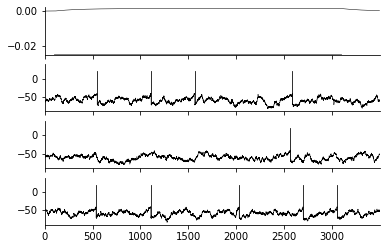

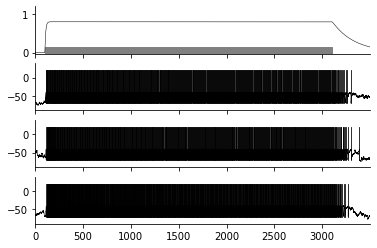

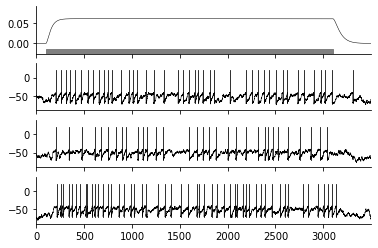

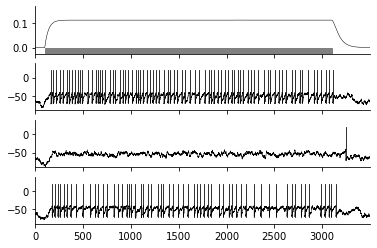

In [34]:
plt.rc('font', size=10)
dt= sim.dt
t= np.arange(0, 3500, dt)
for i in range(4):
    ioff= int((i*paras["trial_time"]+2900.0)/dt)
    toff= ioff*dt
    # plot raw data of the responses - bound receptor, ORN V, PN V, LN V
    figure, ax= plt.subplots(4,sharex=True)
    npts= t.shape[0]
    # find the strongest glomerulus
    ra= state_bufs["ORs_ra"][ioff:ioff+npts,:]
    ra_sum= np.sum(ra, axis=0)
    idx= np.argmax(ra_sum)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    ax[0].plot(t, ra[:,idx],'k',lw=0.5)
    ax[0].set_xlim([0, t[-1]])
    ax[0].set_ylim([-0.025, 1.5*np.amax(ra[:,idx])])
    #ax[0].set_xticklabels([])
    ax[0].add_patch(Rectangle((100, -0.025), 3000, 0.2*np.amax(ra[:,idx]),
            edgecolor = 'grey',
            facecolor = 'grey',
            fill=True))
        
    VORN= state_bufs["ORNs_V"][ioff:ioff+npts,:]
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    ax[1].plot(t, VORN[:,idx*paras["n"]["ORNs"]],'k',lw=0.5)
    plot_spikes(spike_t["ORNs"]-toff, spike_ID["ORNs"], idx, paras["n"]["ORNs"], 0, ax[1])
    ax[1].set_ylim([-90, 40])
    #ax[1].set_xticklabels([])
    VPN= state_bufs["PNs_V"][ioff:ioff+npts,:]
    ax[2].spines['right'].set_visible(False)
    ax[2].spines['top'].set_visible(False)
    ax[2].plot(t, VPN[:,idx*paras["n"]["PNs"]],'k',lw=0.5)
    plot_spikes(spike_t["PNs"]-toff, spike_ID["PNs"], idx, paras["n"]["PNs"], 0, ax[2])
    ax[2].set_ylim([-90, 40])
    #ax[2].set_xticklabels([])
    VLN= state_bufs["LNs_V"][ioff:ioff+npts,:]
    ax[3].spines['right'].set_visible(False)
    ax[3].spines['top'].set_visible(False)
    ax[3].plot(t, VLN[:,idx*paras["n"]["LNs"]],'k',lw=0.5)
    plot_spikes(spike_t["LNs"]-toff, spike_ID["LNs"], idx, paras["n"]["LNs"], 0, ax[3])
    ax[3].set_ylim([-90, 40])
    name= "ex_"+str(i)+"raw_traces.png"
    plt.savefig(name,dpi=300)
plt.show()
